# 4 Delta
### Using QuantLib for Delta Hedging Simulation

Delta hedging is a risk management strategy that aims to reduce, or hedge, the directional risk associated with price movements in the underlying asset. The hedge is achieved by taking an offsetting position in a related derivative, such as options. This notebook demonstrates how to perform delta hedging using the QuantLib library.


In [1]:
import sys
import os

import pandas as pd

current_path = os.getcwd()  # Get current working directory
print("Current Path:", current_path)
current_path = current_path.replace('/samples', '')
print(sys.path)  # Display all module search paths
sys.path.append(current_path)  # Add custom path
print(sys.path)  # Display updated module search paths


Current Path: /Users/yang/PycharmProjects/Option/samples
['/Users/yang/PycharmProjects/Option/samples', '/Users/yang/PycharmProjects/Option', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa']
['/Users/yang/PycharmProjects/Option/samples', '/Users/yang/PycharmProjects/Option', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/Users/yang/PycharmProjects/Option']


In [2]:
# Import necessary libraries
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
import time

from src.utils import plot_fig
from src.QlCalendar import QlCalendar
from src.QlStocks import QlStocks
from src.QlEuropeanOptions import QlEuropeanOptions


In [3]:
# Model Parameters
S0 = 100  # Initial stock price
# strike = 100  # Strike price of the option
r = 0.05  # Risk-free interest rate
# T = 1  # Time to maturity (1 year)
steps = 20  # Number of time steps (trading days)
sigma = 0.3  # Volatility of the underlying stock
dt = 1 / 252
stock_code = 'STCK'

In [4]:
# Initialize calendar and set up dates
start_date = ql.Date(1, 1, 2023)
ql_calendar = QlCalendar(init_date=start_date, init_risk_free_rate=r)
start_date = ql_calendar.init_date
end_date = ql_calendar.cal_date_advance(times=steps, time_unit='days')


In [5]:
# Verify date calculations
print("Maturity Date:", end_date)
print("Days between start and end:", ql_calendar.day_counter.dayCount(start_date, end_date))


Maturity Date: February 3rd, 2023
Days between start and end: 31


In [6]:
# Initialize stock model with Black-Scholes process
ql_stocks = QlStocks(ql_calendar)
ql_stocks.add_black_scholes(stock_code, S0, volatility=sigma)
stock_1 = ql_stocks.stock(stock_code)

In [7]:
# Initialize European call option
option_strike_prices = 100
ql_options = QlEuropeanOptions(stock_1)
ql_options.add_options(
    'call',
    strike_prices = option_strike_prices,
    maturity_dates = end_date
)

codes                types  strike  maturity          
STCK230203C00100000  call   100     February 3rd, 2023    <QuantLib.QuantLib.EuropeanOption; proxy of <S...
Name: options, dtype: object

In [8]:
call = ql_options.option('STCK230203C00100000')
call.analytic_engine()

In [9]:
npv = call.NPV()  # Net Present Value of the option
npv

3.69539486352318

In [10]:
# Quantlib default delta calculation
delta =  call.delta()  # Delta of the option (sensitivity to stock price)
delta

0.5367646739371457

In [11]:
# Numerical calculation of delta 
delta_num_0 = call.delta_numerical(h=0.01)  # Delta of the option (sensitivity to stock price)
delta_num_1 = call.delta_numerical(h=0.001)  # Delta of the option (sensitivity to stock price)
print(delta_num_0, delta_num_1)

0.5367646583718466 0.5367646737854948


## delta_hedge - one day


In [12]:
# Buy one call option:
stock_price = S0
option_qty = 1
npv_0 = call.NPV()
delta_0 = call.delta()
# delta_0 = 1
option_account_value = option_qty * npv_0
# Sell delta stocks
stock_qty = option_qty * delta_0
underlying_hedge_account_value= stock_qty * (-1) * S0
portfolio = option_account_value + underlying_hedge_account_value
print(f'current stock price: {stock_price}, \n'
      f'buy 1 call option and sell {delta_0} stocks \n'
      f'portfolio (call_price - delta * stock_price): {portfolio} \n'
      f'table:')
pd.DataFrame({
    'strike prices': [option_strike_prices],
    'option values': [option_account_value],
    'delta(sell stock quantities)': [delta_0],
    'stock values': [underlying_hedge_account_value],
})


current stock price: 100, 
buy 1 call option and sell 0.5367646739371457 stocks 
portfolio (call_price - delta * stock_price): -49.98107253019139 
table:


,strike prices,option values,delta(sell stock quantities),stock values
0,100,3.695395,0.536765,-53.676467


In [13]:
# 10000 possible prices
N = 10000
rn = np.random.standard_normal(N)
stock_prices = [S0] * N * np.exp(( r -  0.5 * sigma ** 2) * dt + sigma * np.sqrt( dt ) * rn)
stock_prices

array([ 98.2887799 , 103.06204002, 100.34536165, ..., 100.67093937,
        99.80068556,  99.12783033])

In [14]:
npvs = call.NPV_multi(stock_prices)
npvs

array([2.84396966, 5.54559541, 3.88347576, ..., 4.06570653, 3.58931362,
       3.24461574])

In [15]:
option_qty = 1
option_account_value_1 = option_qty * npvs
# Sell delta stocks
# stock_qty = option_qty * delta_0
underlying_hedge_account_value_1 = stock_qty * (-1) * stock_prices
print(f'buy one call option: ')
change_option_values = option_account_value_1 - option_account_value
change_stock_values = underlying_hedge_account_value_1 - underlying_hedge_account_value
pnl = change_option_values - change_stock_values
print('strike prices: ' , option_strike_prices)
df = pd.DataFrame({
    'current stock price': stock_prices,
    'npvs': npvs,
    'changes - option values': change_option_values,
    # 'changes - delta(sell stock quantities)': delta_1 - delta_0,
    'changes - stock values': change_stock_values,
    'pnl': pnl
    
})
df

buy one call option: 
strike prices:  100


,current stock price,npvs,changes - option values,changes - stock values,pnl
0,98.288780,2.843970,-0.851425,0.918523,-1.769948
1,103.062040,5.545595,1.850201,-1.643595,3.493795
2,100.345362,3.883476,0.188081,-0.185378,0.373459
3,101.631194,4.630574,0.935179,-0.875567,1.810746
4,101.060885,4.290194,0.594799,-0.569446,1.164245
...,...,...,...,...,...
9995,97.228925,2.384292,-1.311102,1.487415,-2.798517
9996,97.640066,2.556477,-1.138918,1.266729,-2.405647
9997,100.670939,4.065707,0.370312,-0.360137,0.730448
9998,99.800686,3.589314,-0.106081,0.106985,-0.213066


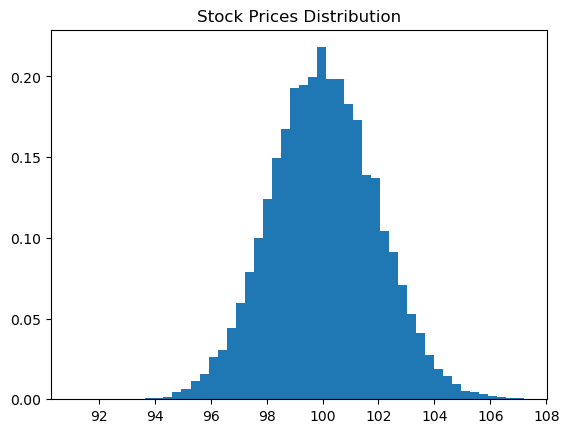

In [16]:
plt.hist(stock_prices, bins=50, density=True)
plt.title("Stock Prices Distribution")  # 添加标题
plt.show()

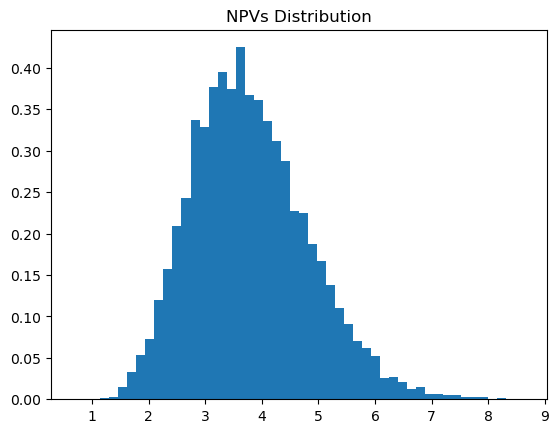

In [17]:
plt.hist(df['npvs'], bins=50, density=True)
plt.title("NPVs Distribution")  # 添加标题
plt.show()

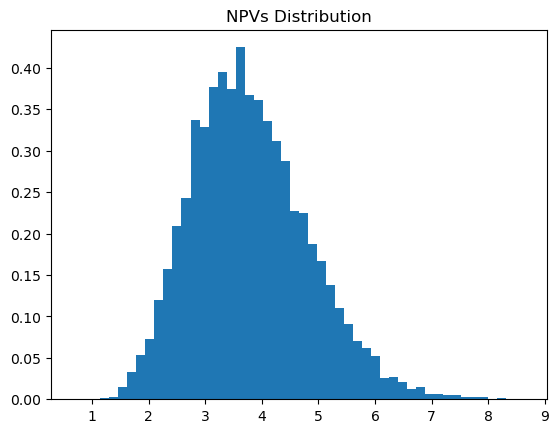

In [18]:
plt.hist(df['npvs'], bins=50, density=True)
plt.title("NPVs Distribution")  # 添加标题
plt.show()

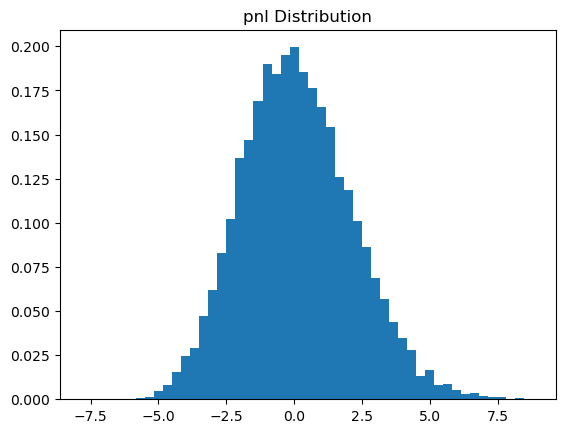

In [19]:
plt.hist(df['pnl'], bins=50, density=True)
plt.title("pnl Distribution")  # 添加标题
plt.show()

In [20]:
stock_prices.mean(), df['pnl'].mean()

(100.03517585414001, 0.11822903652591263)

In [21]:
pnl.mean(), pnl.std()

(0.11822903652591263, 2.041052236878148)

# Volatility Impact Analysis on Option Metrics

## Objective
Analyze how option NPV and Delta values change across a range of volatility values (0.1 to 30) using Black-Scholes and Heston models

### 1, Time to Maturity = 1 month

In [22]:
# the maturity date of the call option to February 3rd, 2023
# Time to Maturity = 1 month
ql_calendar.set_today(ql.Date(3,1,2023))

stock_1.set_today_price(102)

call.stock_vol_quote.setValue(sigma)

print(call.maturity_date, ql_calendar.today(), sigma, call.delta())

February 3rd, 2023 January 3rd, 2023 0.3 0.6250554683241951


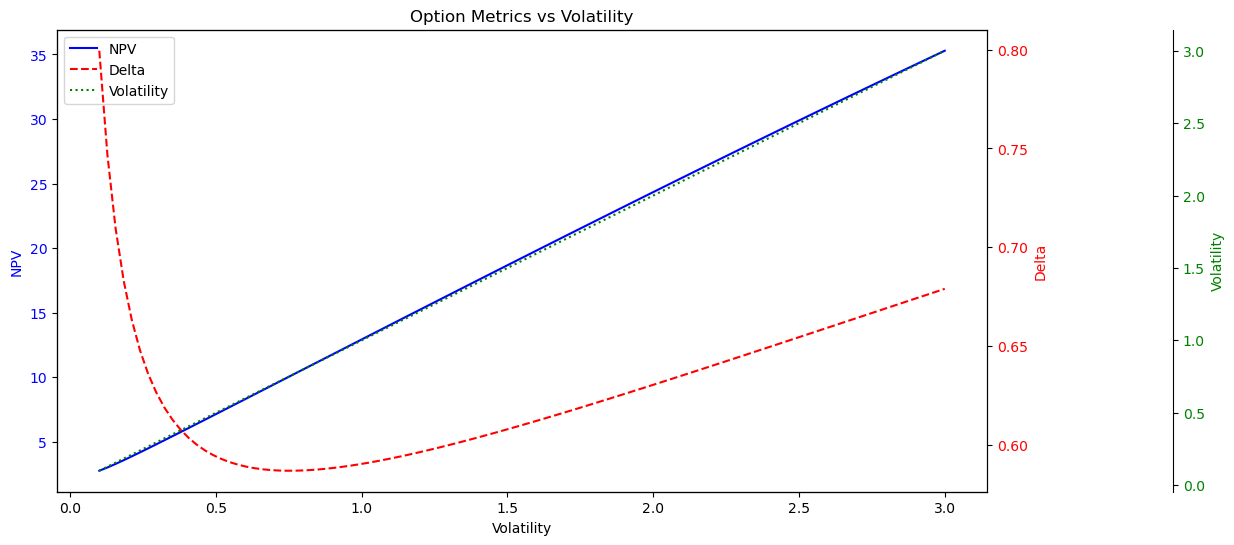

In [23]:
# 初始化数据存储列表
vol_list = np.linspace(0.1, 3, 105)  # 生成0.1到30的100个均匀间隔值
npv_list = []
delta_list = []

# 循环测试不同波动率
for i in vol_list:
    call.stock_vol_quote.setValue(i)
    npv_list.append(call.NPV())
    delta_list.append(call.delta())

# 创建图表和主Y轴（NPV）
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(vol_list, npv_list, 'b-', label='NPV')
ax1.set_xlabel('Volatility')
ax1.set_ylabel('NPV', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 添加右侧Y轴（Delta）
ax2 = ax1.twinx()
ax2.plot(vol_list, delta_list, 'r--', label='Delta')
ax2.set_ylabel('Delta', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# 添加第三个Y轴（Volatility本身，演示用）
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))  # 向右偏移20%
ax3.plot(vol_list, vol_list, 'g:', label='Volatility')
ax3.set_ylabel('Volatility', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# 合并图例
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Option Metrics vs Volatility')
plt.show()

### 2, Time to Maturity = 1 day


In [24]:
# the maturity date of the call option to February 3rd, 2023
# Time to Maturity = 1 day
ql_calendar.set_today(ql.Date(2,2,2023))

stock_1.set_today_price(98)

call.stock_vol_quote.setValue(sigma)

print(call.maturity_date, ql_calendar.today(), sigma, call.delta())

February 3rd, 2023 February 2nd, 2023 0.3 0.10204252043478847


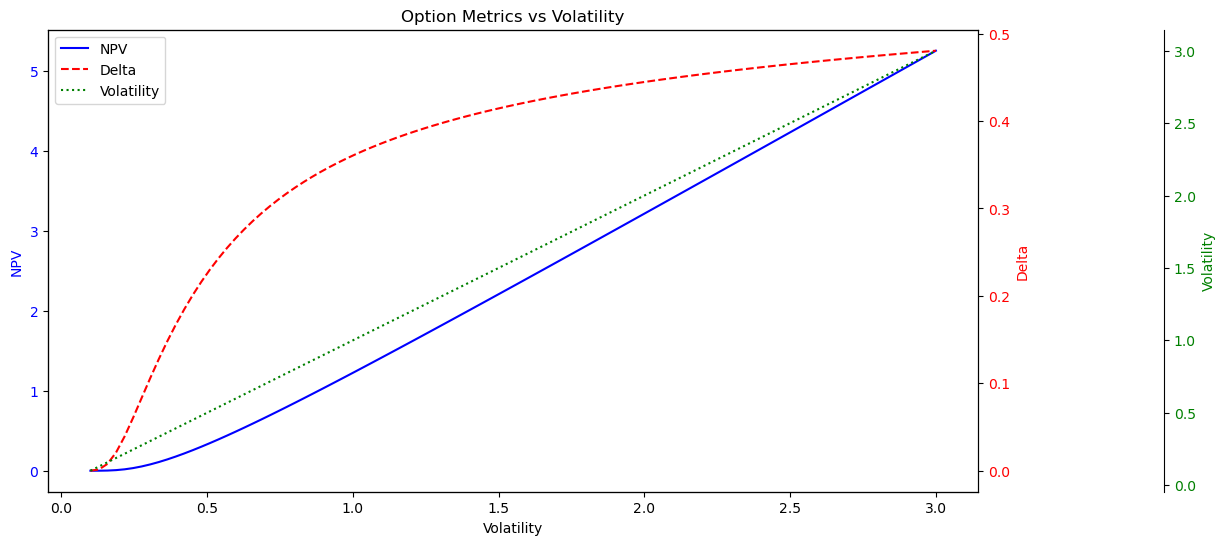

In [25]:
# 初始化数据存储列表
vol_list = np.linspace(0.1, 3, 100)  # 生成0.1到30的100个均匀间隔值
npv_list = []
delta_list = []

# 循环测试不同波动率
for i in vol_list:
    call.stock_vol_quote.setValue(i)
    npv_list.append(call.NPV())
    delta_list.append(call.delta())

# 创建图表和主Y轴（NPV）
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(vol_list, npv_list, 'b-', label='NPV')
ax1.set_xlabel('Volatility')
ax1.set_ylabel('NPV', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 添加右侧Y轴（Delta）
ax2 = ax1.twinx()
ax2.plot(vol_list, delta_list, 'r--', label='Delta')
ax2.set_ylabel('Delta', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# 添加第三个Y轴（Volatility本身，演示用）
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))  # 向右偏移20%
ax3.plot(vol_list, vol_list, 'g:', label='Volatility')
ax3.set_ylabel('Volatility', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# 合并图例
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Option Metrics vs Volatility')
plt.show()

# 3D Visualization Enhancement

## Objective
Enhance the existing 3D plots of Option NPV and Delta, enabling clearer analysis of volatility sensitivity at this specific price level.


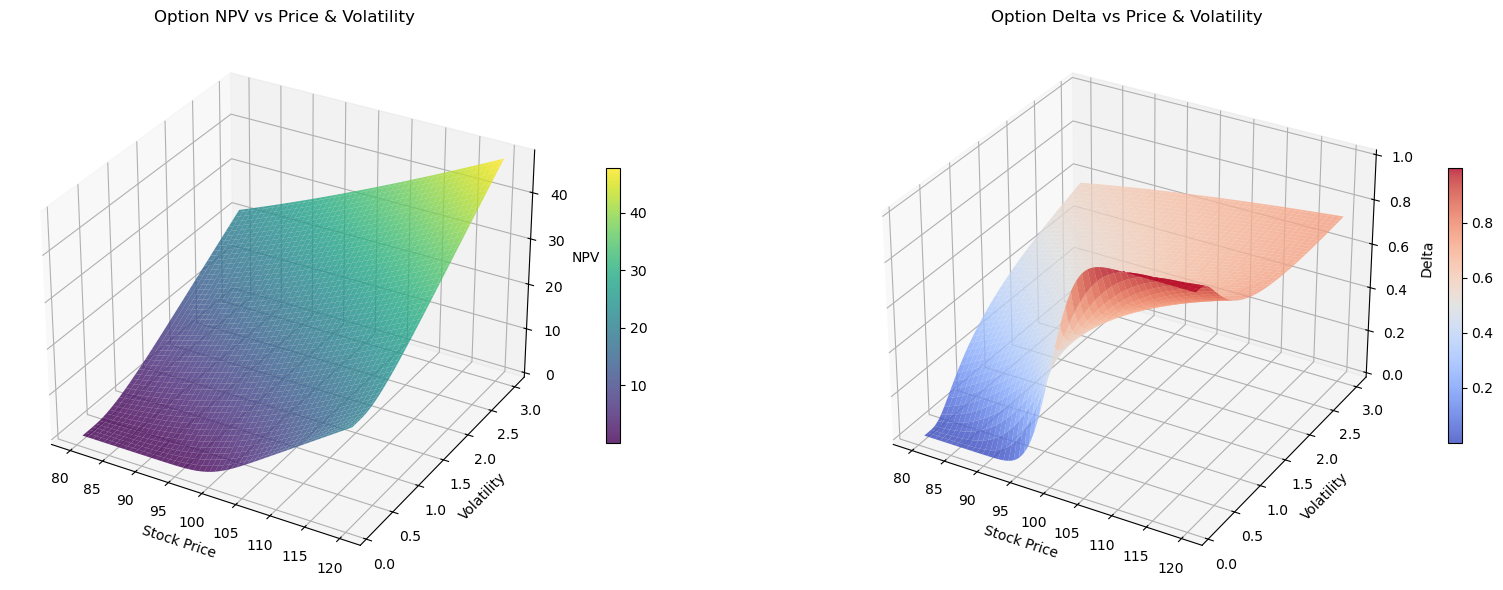

In [26]:
# Time to Maturity = 1 month
ql_calendar.set_today(ql.Date(3,1,2023))

# 初始化数据存储列表
vol_list = np.linspace(0.1, 3, 100)  # 生成0.1到30的100个均匀间隔值
price_list = np.linspace(80, 120, 100)
npv_list = []
delta_list = []

# 循环测试不同波动率
for price in price_list:
    for i in vol_list:
        stock_1.set_today_price(price)
        call.stock_vol_quote.setValue(i)
        npv_list.append(call.NPV())
        delta_list.append(call.delta())

# Prepare data
vol_grid, price_grid = np.meshgrid(vol_list, price_list)
npv_array = np.array(npv_list).reshape(len(price_list), len(vol_list))
delta_array = np.array(delta_list).reshape(len(price_list), len(vol_list))

# Create figure with two subplots
fig = plt.figure(figsize=(18, 6))

# 1. NPV Surface Plot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(price_grid, vol_grid, npv_array,
                        cmap='viridis', alpha=0.8)
ax1.set_title('Option NPV vs Price & Volatility')
ax1.set_xlabel('Stock Price')
ax1.set_ylabel('Volatility')
ax1.set_zlabel('NPV')
fig.colorbar(surf1, ax=ax1, shrink=0.5)

# 2. Delta Surface Plot
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(price_grid, vol_grid, delta_array,
                        cmap='coolwarm', alpha=0.8)
ax2.set_title('Option Delta vs Price & Volatility')
ax2.set_xlabel('Stock Price')
ax2.set_ylabel('Volatility')
ax2.set_zlabel('Delta')
fig.colorbar(surf2, ax=ax2, shrink=0.5)

# Adjust view angles for better visualization
# ax1.view_init(elev=10, azim=45)
# ax2.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

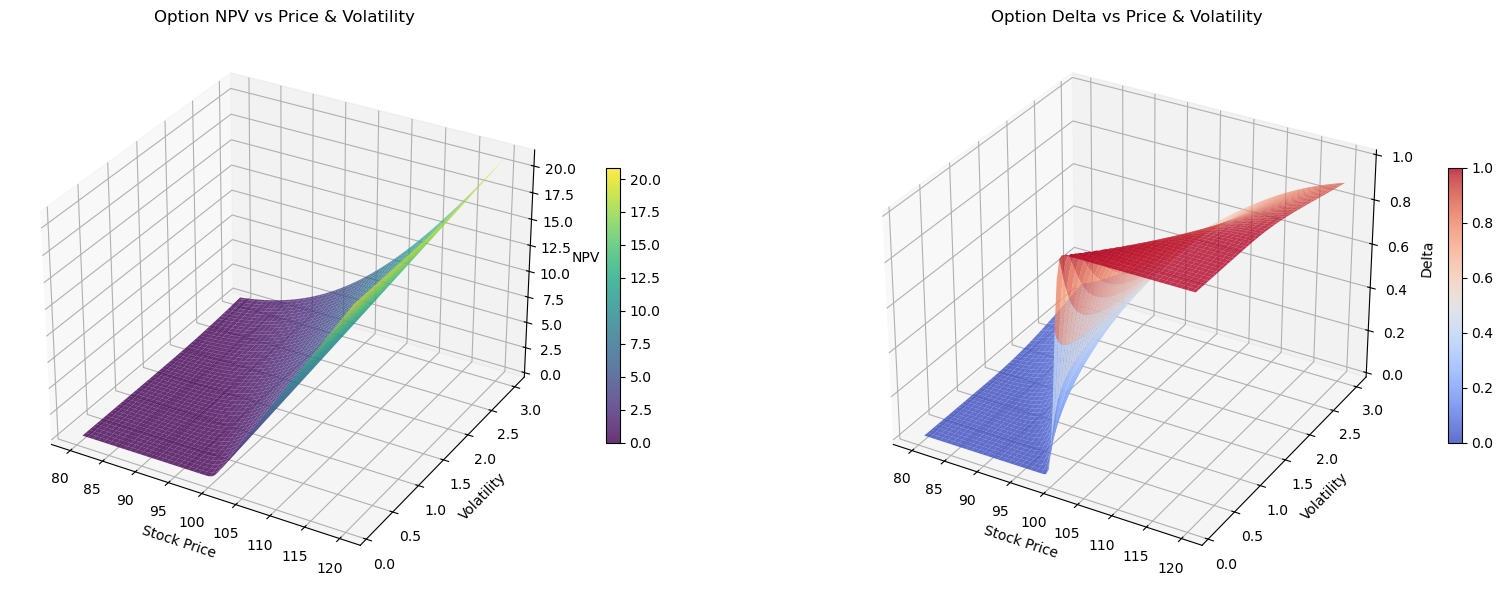

In [27]:
# Time to Maturity = 1 day
ql_calendar.set_today(ql.Date(2,2,2023))

# 初始化数据存储列表
vol_list = np.linspace(0.1, 3, 100)  # 生成0.1到30的100个均匀间隔值
price_list = np.linspace(80, 120, 100)
npv_list = []
delta_list = []

# 循环测试不同波动率
for price in price_list:
    for i in vol_list:
        stock_1.set_today_price(price)
        call.stock_vol_quote.setValue(i)
        npv_list.append(call.NPV())
        delta_list.append(call.delta())
# Prepare data
vol_grid, price_grid = np.meshgrid(vol_list, price_list)
npv_array = np.array(npv_list).reshape(len(price_list), len(vol_list))
delta_array = np.array(delta_list).reshape(len(price_list), len(vol_list))

# Create figure with two subplots
fig = plt.figure(figsize=(18, 6))

# 1. NPV Surface Plot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(price_grid, vol_grid, npv_array,
                        cmap='viridis', alpha=0.8)
ax1.set_title('Option NPV vs Price & Volatility')
ax1.set_xlabel('Stock Price')
ax1.set_ylabel('Volatility')
ax1.set_zlabel('NPV')
fig.colorbar(surf1, ax=ax1, shrink=0.5)

# 2. Delta Surface Plot
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(price_grid, vol_grid, delta_array,
                        cmap='coolwarm', alpha=0.8)
ax2.set_title('Option Delta vs Price & Volatility')
ax2.set_xlabel('Stock Price')
ax2.set_ylabel('Volatility')
ax2.set_zlabel('Delta')
fig.colorbar(surf2, ax=ax2, shrink=0.5)

# Adjust view angles for better visualization
# ax1.view_init(elev=10, azim=45)
# ax2.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()